# 9 Review of `rampup-v1` with A2C

In [2]:
import os
import subprocess
import numpy as np
import webbrowser
import gym
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3.common.cmd_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike

from plan_opt.demand import Demand
from plan_opt.demand_small_samples import four_weeks_uprising

## Environments and Evaluation callbacks
In this notebook training and evaluation combinations between the simple 4-weeks demand and various 3 years demands are evaluated.

`env_cb_creator` quickly creates environments and callbacks, either from an existing intance of `Demand`, or from a seed specified. The data is displayed.

In [2]:
def env_cb_creator(demand=None, seed=None):
    # if exactly one argument is not none
    if (demand is None) ^ (seed is None):
        if demand is None:
            demand = Demand(seed=seed)
            demand.generate_demand()
            demand.show()
        else:
            demand.show(only_data=True)
        env = gym.make("rampup-v1").create(demand)
        callback = EvalCallback(
            env,
            best_model_save_path="./logs/",
            log_path="./logs/",
            eval_freq=100,
            deterministic=True,
            render=False,
            verbose=0,
        )
        return env, callback, demand
    else:
        print('Please provide either "demand" or a "seed"!')

### 4W -> `four_weeks_uprising` demand
Using an overseeable demand for four weeks only.
The environment is created from the Gym registry with the custom 4 weeks demand.

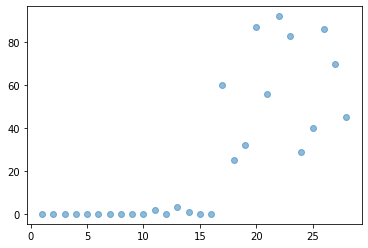

In [3]:
demand_4W = Demand(period=len(four_weeks_uprising), data=four_weeks_uprising)
env_4W, eval_callback_4W, demand_4W = env_cb_creator(demand=demand_4W)

In [4]:
from stable_baselines3.common.env_checker import check_env
print(env_4W.observation_space)
env_4W._retrieve_obs()

Box(1, 5, 3)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

### 3YS1256 -> 3 years demand at seed 1256

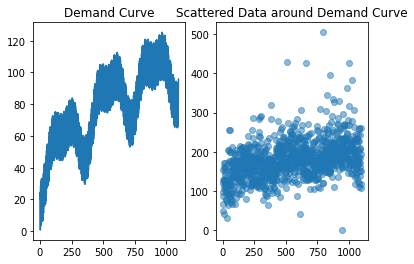

In [5]:
env_3YS1256, eval_callback_3YS1256, demand_3YS1256 = env_cb_creator(seed=1256)

### Quick Observation Space Check
The observation is a feature vector, not an image, thus we use the MlpPolicy and can ignore warnings regarding CnnPolicy use on the provided environment.

In [6]:
env_4W.observation_space.__dict__

{'dtype': dtype('uint8'),
 'shape': (1, 5, 3),
 'low': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 'high': array([[[255, 255, 255],
         [  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1]]], dtype=uint8),
 'bounded_below': array([[[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]]]),
 'bounded_above': array([[[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]]]),
 'np_random': RandomState(MT19937) at 0x7F852A87C840}

In [7]:
check_env(env_4W)

/Users/seppmacmini/opt/miniconda3/envs/rl/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:33: UserWarning: It seems that your observation space is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(
/Users/seppmacmini/opt/miniconda3/envs/rl/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:41: UserWarning: The minimal resolution for an image is 36x36 for the default CnnPolicy. You might need to use a custom `cnn_extractor` cf https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  warnings.warn(


## Training and Evaluation

The procedure to train and evaluate models on different environments is defined in `train_and_evaluate()`. Due to unstable training observed, as [recommended by SB3](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html?highlight=learn#stable_baselines3.a2c.A2C.learn), I change the optimizer to RMSpropTFLike for more stable training.

The environment is not vectorized for parallel use, as rewards during the evaluation callback do not make it to the tensorboard.

In [8]:
def train_and_evaluate(train_env, eval_env, eval_callbacks, tb_log_name, episodes=50):

    model = A2C(
        "MlpPolicy",
        train_env,
        policy_kwargs=dict(optimizer_class=RMSpropTFLike),
        tensorboard_log=tensorboard_log,
        verbose=0,
    )
    model.learn(
        total_timesteps=timesteps, callback=eval_callbacks, tb_log_name=tb_log_name
    )

    # eval_env.fill_table = True
    # obs = eval_env._set_initial_state(initial_state_status=3)
    # while not eval_env.done:
    #    action, _states = model.predict(obs, deterministic=True)
    #    obs, reward, done, info = eval_env.step(action)
    # eval_env.render()

    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=episodes)
    economic_potential = eval_env.demand.economic_potential()
    lost_potential = economic_potential - max(mean_reward, 0)
    lost_potential_perc = round(lost_potential / economic_potential * 100, 4)

    summary = "POLICY EVALUATION RESULTS"
    summary += f"\nEvaluated episodes:\t{episodes}"
    summary += f"\nMean reward:\t\t{mean_reward}"
    summary += f"\nStandard deviation:\t{std_reward}"
    summary += f"\nEconomic potential:\t{economic_potential}"
    summary += f"\nLost potential:\t\t{lost_potential} ({lost_potential_perc}%)"
    print(summary)
    # display(eval_env.episode_table)

### Configuration

In [3]:
timesteps = 25000
repetitions = 2
long_running = True
tensorboard_log = "logs/rampup_tensorboard/"
tb_log_suffix = f"{str(timesteps)[:-3]}k"
print(f"Tensorboard logs saved with suffix {tb_log_suffix}")

Tensorboard logs saved with suffix 25k


#### Training 4W (4 weeks), Evaluation 4W

In [10]:
%%time
for i in range(repetitions):
    train_and_evaluate(
        env_4W, env_4W, eval_callback_4W, f"A2C_{tb_log_suffix}_train4W_eval4W"
    )

POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		40800.0
Standard deviation:	20066.140635408694
Economic potential:	48000
Lost potential:		7200.0 (15.0%)
POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		37530.0
Standard deviation:	16667.456314627016
Economic potential:	48000
Lost potential:		10470.0 (21.8125%)
CPU times: user 51.2 s, sys: 936 ms, total: 52.2 s
Wall time: 51.2 s


#### Training 3YR (3 years random), Evaluation 4W

In [11]:
%%time
for i in range(repetitions):
    train_and_evaluate(
        "rampup-v1", env_4W, eval_callback_4W, f"A2C_{tb_log_suffix}_train3YR_eval4W"
    )

POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		25560.0
Standard deviation:	12200.672112633796
Economic potential:	48000
Lost potential:		22440.0 (46.75%)
POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		17640.0
Standard deviation:	16118.014766093249
Economic potential:	48000
Lost potential:		30360.0 (63.25%)
CPU times: user 51.2 s, sys: 1.01 s, total: 52.2 s
Wall time: 51.2 s


#### Training 4W (4 weeks), Evaluation 3YS1256

In [12]:
%%time
if long_running:
    for i in range(repetitions):
        train_and_evaluate(
            env_4W,
            env_3YS1256,
            eval_callback_3YS1256,
            f"A2C_{tb_log_suffix}_train4W_eval3YS1256",
        )

POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		-230540.0
Standard deviation:	157977.11353230884
Economic potential:	16161500
Lost potential:		16161500 (100.0%)
POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		1015460.0
Standard deviation:	511012.7673551807
Economic potential:	16161500
Lost potential:		15146040.0 (93.7168%)
CPU times: user 8min 7s, sys: 1.54 s, total: 8min 9s
Wall time: 8min 9s


#### Training 3YR, Evaluation 3YS1256

In [13]:
%%time
if long_running:
    for i in range(repetitions):
        train_and_evaluate(
            "rampup-v1",
            env_3YS1256,
            eval_callback_3YS1256,
            f"A2C_{tb_log_suffix}_train3YR_eval3YS1256",
        )

POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		7355400.0
Standard deviation:	4277308.008549303
Economic potential:	16161500
Lost potential:		8806100.0 (54.4881%)
POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		8782200.0
Standard deviation:	4843186.137244779
Economic potential:	16161500
Lost potential:		7379300.0 (45.6597%)
CPU times: user 8min 32s, sys: 1.64 s, total: 8min 34s
Wall time: 8min 34s


#### Training 3YS1256, Evaluation 3YS1256

In [14]:
%%time
if long_running:
    for i in range(repetitions):
        train_and_evaluate(
            env_3YS1256,
            env_3YS1256,
            eval_callback_3YS1256,
            f"A2C_{tb_log_suffix}_train3YS1256_eval3YS1256",
        )

POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		6326220.0
Standard deviation:	4082528.82556878
Economic potential:	16161500
Lost potential:		9835280.0 (60.8562%)
POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		7368780.0
Standard deviation:	4863363.125615853
Economic potential:	16161500
Lost potential:		8792720.0 (54.4053%)
CPU times: user 8min 26s, sys: 1.51 s, total: 8min 27s
Wall time: 8min 27s


#### Training 3YS1256, Evaluation 3YS3348

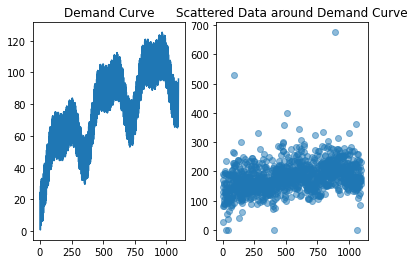

POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		8055780.0
Standard deviation:	4208245.070287613
Economic potential:	16223500
Lost potential:		8167720.0 (50.345%)
POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		9527880.0
Standard deviation:	4479502.314498788
Economic potential:	16223500
Lost potential:		6695620.0 (41.2711%)
CPU times: user 8min 18s, sys: 1.66 s, total: 8min 19s
Wall time: 8min 20s


In [15]:
%%time
if long_running:
    env_3YS3348, eval_callback_3Y3348, demand_3Y3348 = env_cb_creator(seed=3348)
    for i in range(repetitions):
        train_and_evaluate(
            env_3YS1256,
            env_3YS3348,
            eval_callback_3Y3348,
            f"A2C_{tb_log_suffix}_train3YS1256_eval3YS3348",
        )

## Results (move to env that cares for punishing illegal moves)

With illegal punishment, training and evaluation on 4W! Evaluation, most often, gets stuck and remains negative. Only some evaluations turn out positive.

![Evaluation](docs/nb08-eval.png)

### Tensorboard
Start Tensorboard on port 6006 and open it in a browser.

In [4]:
if 1 == 1:
    pid = subprocess.Popen(
        ["tensorboard", "--logdir", f"./{tensorboard_log}", "--port", "6006"]
    )
    os.system("sleep 5")
    webbrowser.open("http://localhost:6006")

In [17]:
# Alternatively, load the TensorBoard notebook extension
# %load_ext tensorboard
# %tensorboard --logdir ./rampup_tensorboard/

To wrap up, kill the Tensorboard process.

In [18]:
if 1 == 0:
    os.system("kill -9 $(lsof -t -i:6006)")